# Project: Advanced Lane Lines Detection

Steps of the projects:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import pickle
import ipywidgets as widgets

from moviepy.editor import VideoFileClip
from IPython.display import HTML

#all the helper functions to build the pipeline in this project
import advancedCV as aCV

## Camera Calibration

In [2]:
def calibrate_camera():    
    color_channels = 3 #Red, Green, Blue
    #Prepare object points
    #The number of inside corners in x
    nx = 9
    #The number of inside corners in y
    ny = 6
    objp = np.zeros((nx*ny, color_channels), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, color_channels - 1)
    
    objpoints = []
    imgpoints = []
    
    #wildcard: matching all expressions.
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for idx, imname in enumerate(images):
        img = cv2.imread(imname)
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret == True:
            
            objpoints.append(objp)
            
            imgpoints.append(corners)
            
    #Do camera calibration given object points and image points
    return objpoints, imgpoints

objpoints, imgpoints = calibrate_camera()

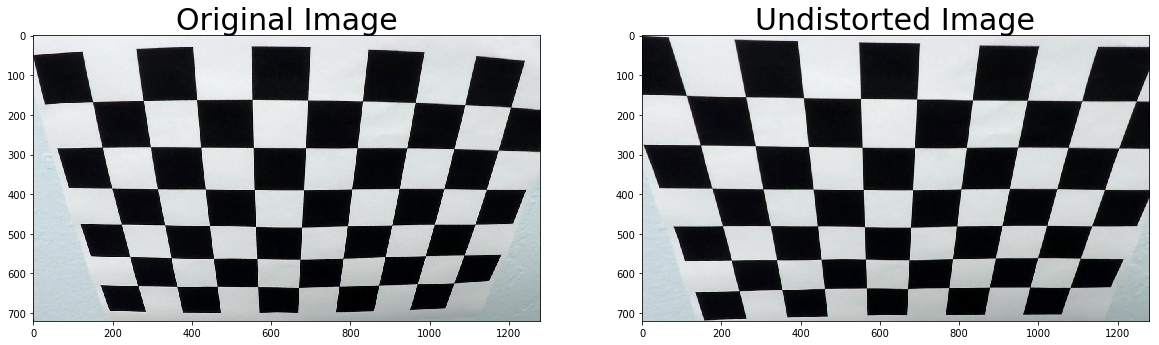

In [3]:
#Check on a random image
test_img = cv2.imread('camera_cal/calibration2.jpg')
test_img_size = (test_img.shape[1], test_img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img_size, None, None)

dst = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

f.savefig('output_images/cameraCalibration.png')

## Undistort a real road image

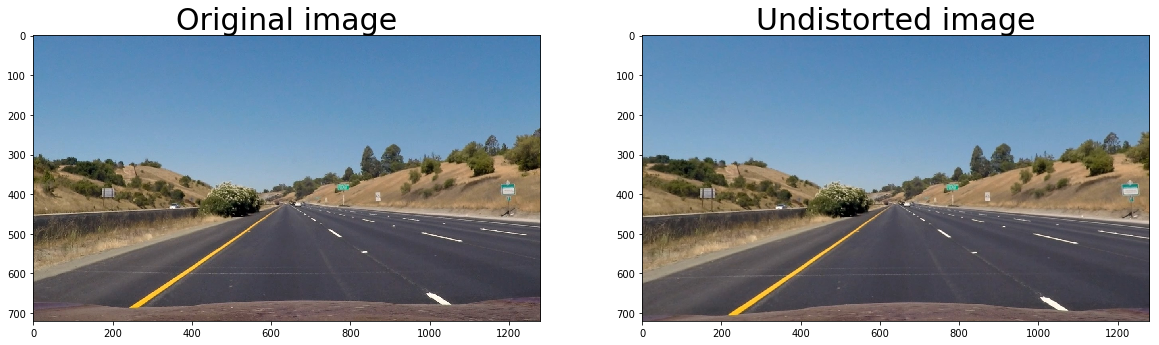

In [4]:
road_img = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
road_img = cv2.resize(road_img, (1280, 720))
road_img_size = (road_img.shape[1], road_img.shape[0])

road_dst = cv2.undistort(road_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(road_img)
ax1.set_title("Original image", fontsize=30)
ax2.imshow(road_dst)
ax2.set_title("Undistorted image", fontsize=30)

f.savefig('output_images/roadUndistortion.png')

## Create thresholded binary image

Investigate Red-Green-Blue, Hue-Light-Saturation, Hue-Saturation-Value color spaces.

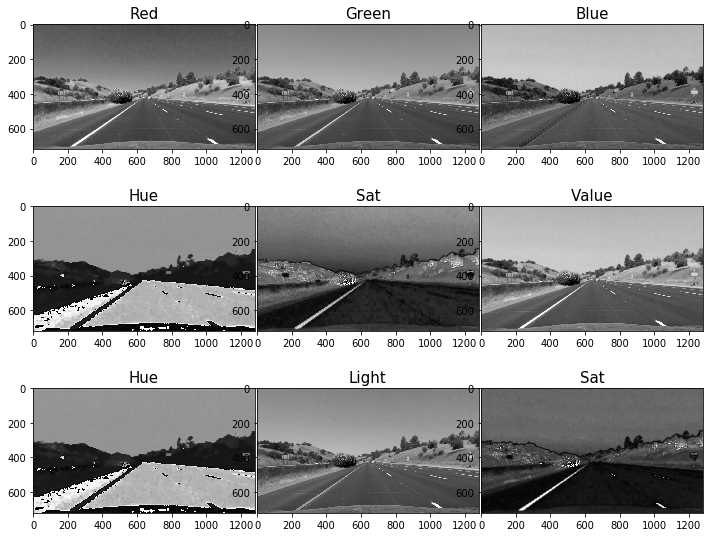

In [5]:
RGB_red = road_dst[:,:,0]
RGB_green = road_dst[:,:,1]
RGB_blue = road_dst[:,:,2]

road_dst_HLS = cv2.cvtColor(road_dst, cv2.COLOR_RGB2HLS)
HLS_hue = road_dst_HLS[:,:,0]
HLS_light = road_dst_HLS[:,:,1]
HLS_sat = road_dst_HLS[:,:,2]

road_dst_HSV = cv2.cvtColor(road_dst, cv2.COLOR_RGB2HSV)
HSV_hue = road_dst_HSV[:,:,0]
HSV_sat = road_dst_HSV[:,:,1]
HSV_val = road_dst_HSV[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(12,10))

f.subplots_adjust(hspace=.01, wspace = .01)

ax1[0].imshow(RGB_red, cmap="gray")
ax1[0].set_title("Red", fontsize=15)
ax1[1].imshow(RGB_green, cmap="gray")
ax1[1].set_title("Green", fontsize=15)
ax1[2].imshow(RGB_blue, cmap="gray")
ax1[2].set_title("Blue", fontsize=15)

ax2[0].imshow(HSV_hue, cmap="gray")
ax2[0].set_title("Hue", fontsize=15)
ax2[1].imshow(HSV_sat, cmap="gray")
ax2[1].set_title("Sat", fontsize=15)
ax2[2].imshow(HSV_val, cmap="gray")
ax2[2].set_title("Value", fontsize=15)

ax3[0].imshow(HLS_hue, cmap="gray")
ax3[0].set_title("Hue", fontsize=15)
ax3[1].imshow(HLS_light, cmap="gray")
ax3[1].set_title("Light", fontsize=15)
ax3[2].imshow(HLS_sat, cmap="gray")
ax3[2].set_title("Sat", fontsize=15)

f.savefig("output_images/channelInvestigation.png")

It appeared in the plots that:
- Channel __Red__ does the best in RGB color space.
- Channel __Value__ do relatively well in HLS space.
- Channel __Sat__ does the best in the HLS space.

Having this information, we now want to extract the lane lines using upper and lower thresholds in different channels. In order to help tune these parameters, I built a small tool to quickly demonstrate the result applied by a range of thresholds supporting a single channel at a time.

- Red [175, 255] (RGB)

- Val [170, 255] (HSV)

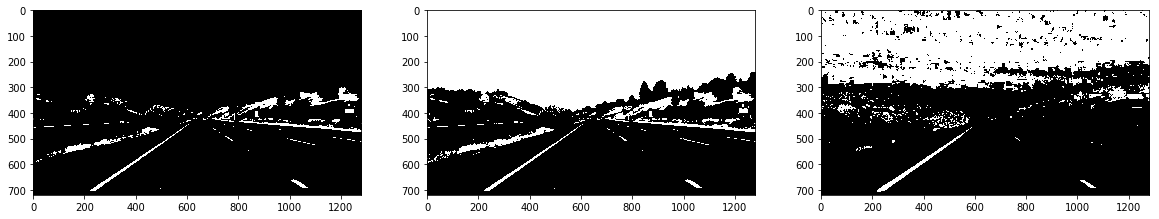

In [6]:
#threshold
red_thres = (175, 255)
val_thres = (170, 255)
sat_thres = (100, 255)

red_binary = np.zeros_like(RGB_red)
red_binary[(RGB_red >= red_thres[0]) & (RGB_red <= red_thres[1])] = 1

val_binary = np.zeros_like(HSV_val)
val_binary[(HSV_val >= val_thres[0]) & (HSV_val <= val_thres[1])] = 1

sat_binary = np.zeros_like(HLS_sat)
sat_binary[(HLS_sat >= sat_thres[0]) & (HLS_sat <= sat_thres[1])] = 1

figure, axis = plt.subplots(1,3, figsize = (20,20))

axis[0].imshow(red_binary, cmap='gray')
axis[1].imshow(val_binary, cmap='gray')
axis[2].imshow(sat_binary, cmap='gray')

figure.savefig("output_images/three_separate_channels.png")

### Sobel, Gradient and Direction

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    try:
        #grayscale the image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        if orient=='y':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= sobel_kernel)
        else:
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= sobel_kernel)
        
        #Take the absolute value of the derivate or gradient
        abs_sobel = np.absolute(sobel)
        
        scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
        
        binary_output = np.zeros_like(scaled_sobel)
        
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        
    except Exception as e:
        print(e)
        
        binary_output = None
    
    finally:
        return binary_output
    
def mag_thresh(img, sobel_kernel = 3, thresh = (0, 255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
        sobel = (sobel_x**2 + sobel_y**2)**0.5
        
        scaled_sobel = np.uint8(sobel*255/np.max(sobel))
        
        binary_output = np.zeros_like(scaled_sobel)
        
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)]=1
            
    except Exception as e:
        
        print(e)
        binary_output = None
    
    finally:
        return binary_output
    
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    thresh_min, thresh_max = thresh[0], thresh[1]
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #Calculate gradient direction
        #Apply threshold
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        sobel_angle = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))

        binary_output = np.zeros_like(sobel_angle)

        #binary mask where direction thresholds are met
        binary_output[(sobel_angle >= thresh_min) & (sobel_angle <= thresh_max)] = 1
    except Exception as e:
        print(e)
        binary_output = None
        
    finally:
        return binary_output

### Abs sobel threshold

x direction: [40, 255]

y direction: [60, 200]

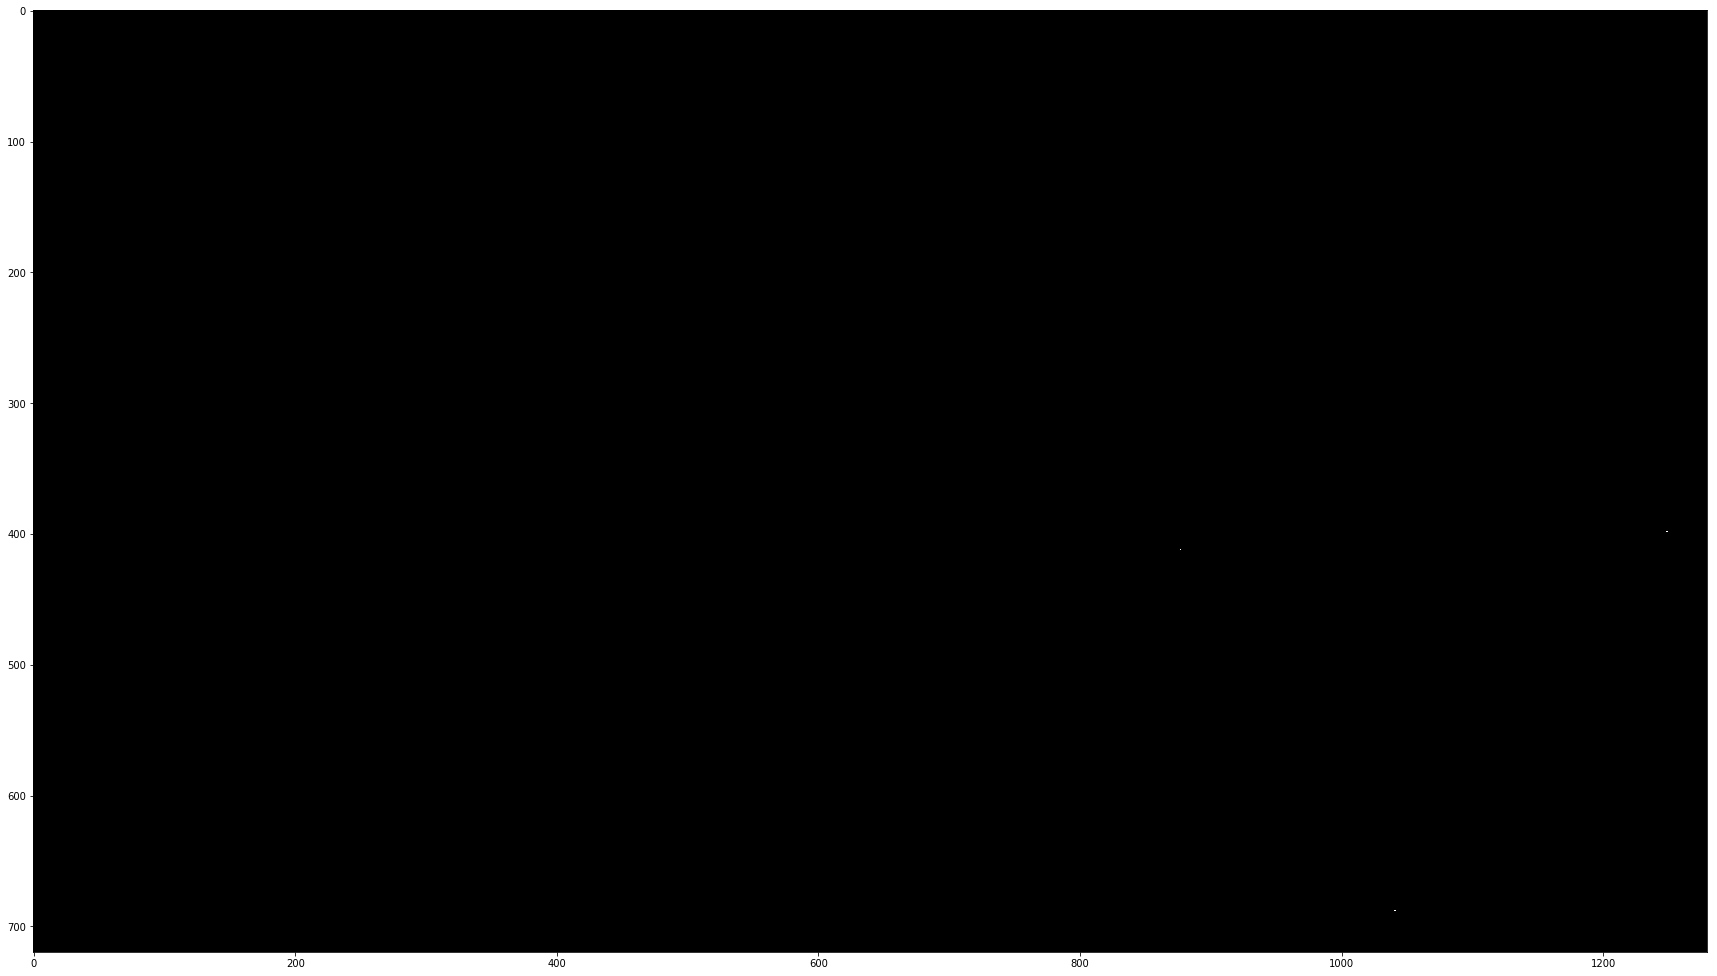

In [8]:
@widgets.interact(min_threshold = (0, 255, 1), max_threshold = (0,255, 1) )
def adjust_sobel_x(min_threshold, max_threshold):
    global road_dst
    figure, axis = plt.subplots(1, 1, figsize = (30,30))
    sobelx_img = abs_sobel_thresh(road_dst, 'x', 3, (min_threshold, max_threshold))
    axis.imshow(sobelx_img, cmap='gray')

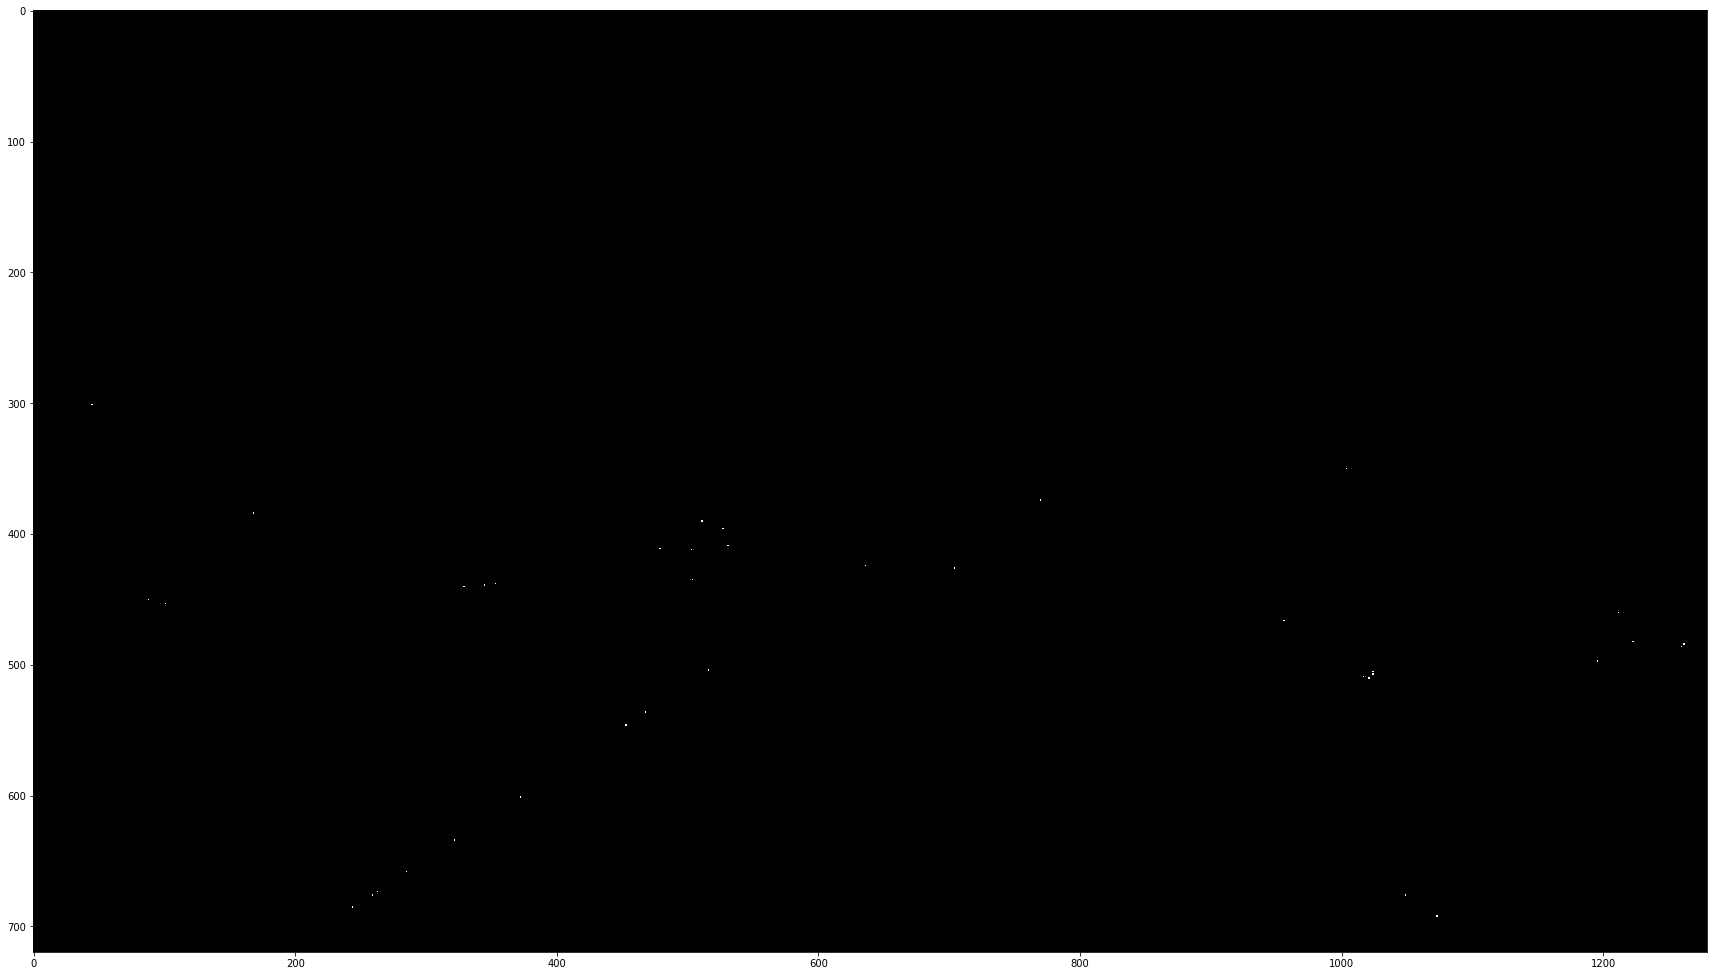

In [9]:
@widgets.interact(min_threshold = (0, 255, 1), max_threshold = (0,255, 1) )
def adjust_sobel_y(min_threshold, max_threshold):
    global road_dst
    figure, axis = plt.subplots(1, 1, figsize = (30,30))
    sobely_img = abs_sobel_thresh(road_dst, 'y', 3, (min_threshold, max_threshold))
    axis.imshow(sobely_img, cmap='gray')

### Magnitude threshold

Choose: [60, 255]

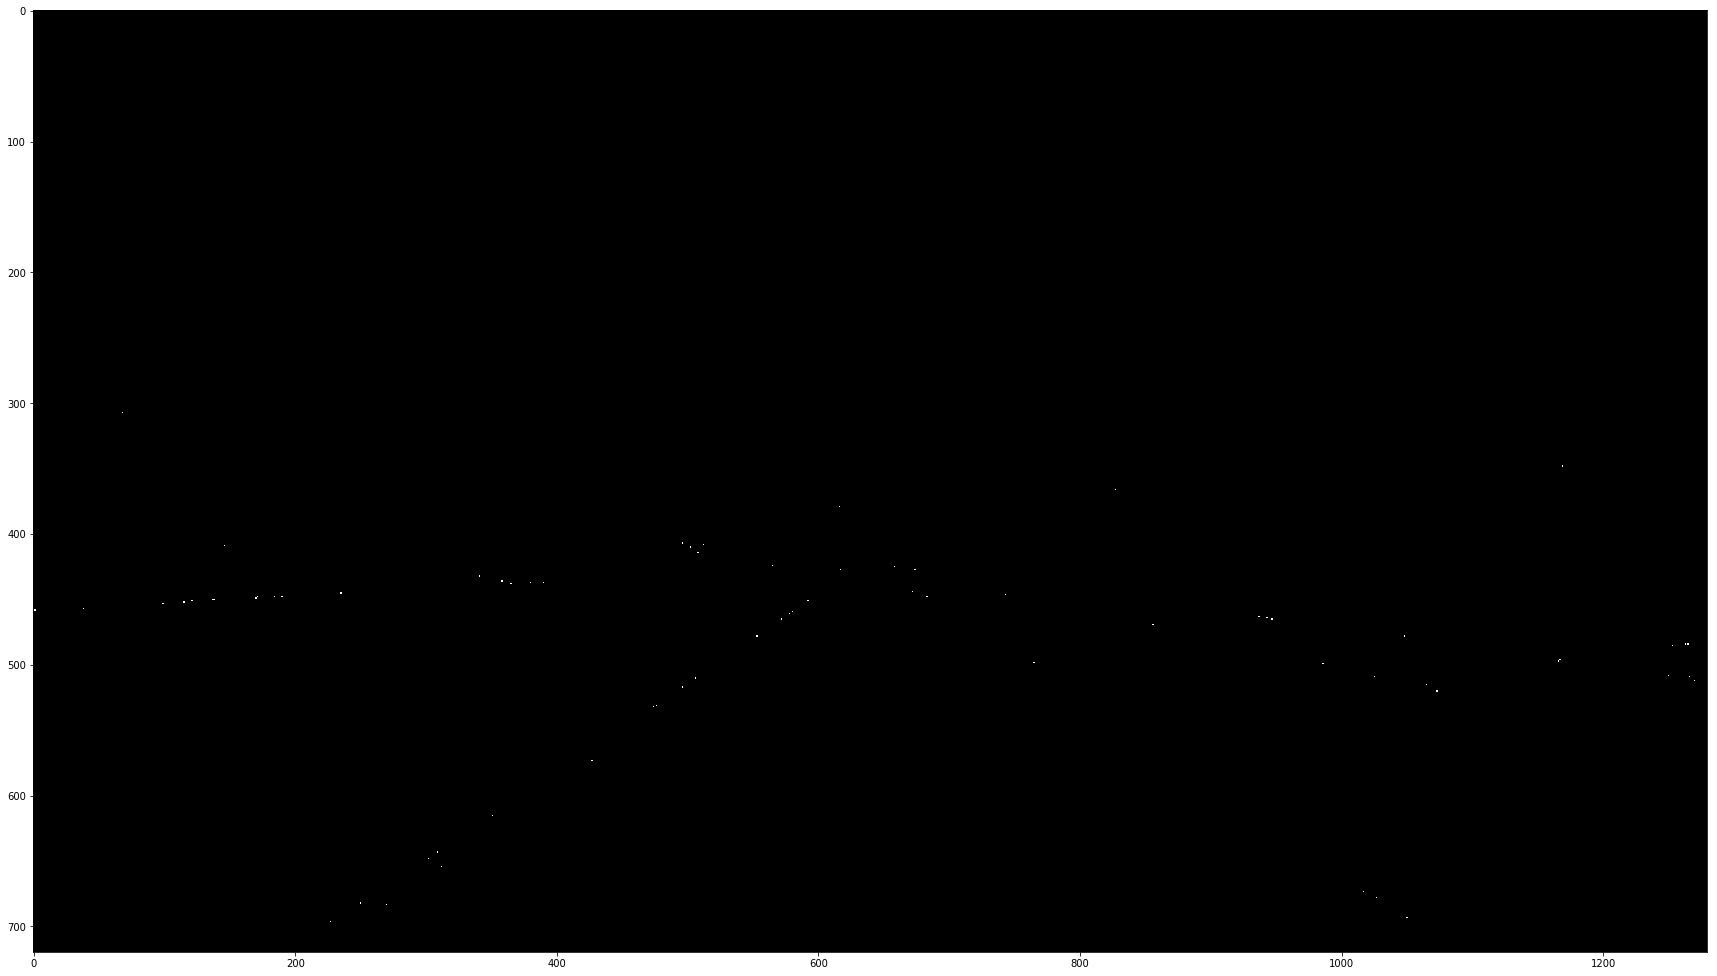

In [10]:
#Live widget to tune the magnitude thresholds
@widgets.interact(min_threshold = (0, 255, 1), max_threshold = (0,255, 1) )
def adjust_mag(min_threshold, max_threshold):
    global road_dst
    figure, axis = plt.subplots(1, 1, figsize = (30,30))
    sobely_img = mag_thresh(road_dst, 3, (min_threshold, max_threshold))
    axis.imshow(sobely_img, cmap='gray')

### Angle direction threshold

angle: [$40^o, 75^o$]


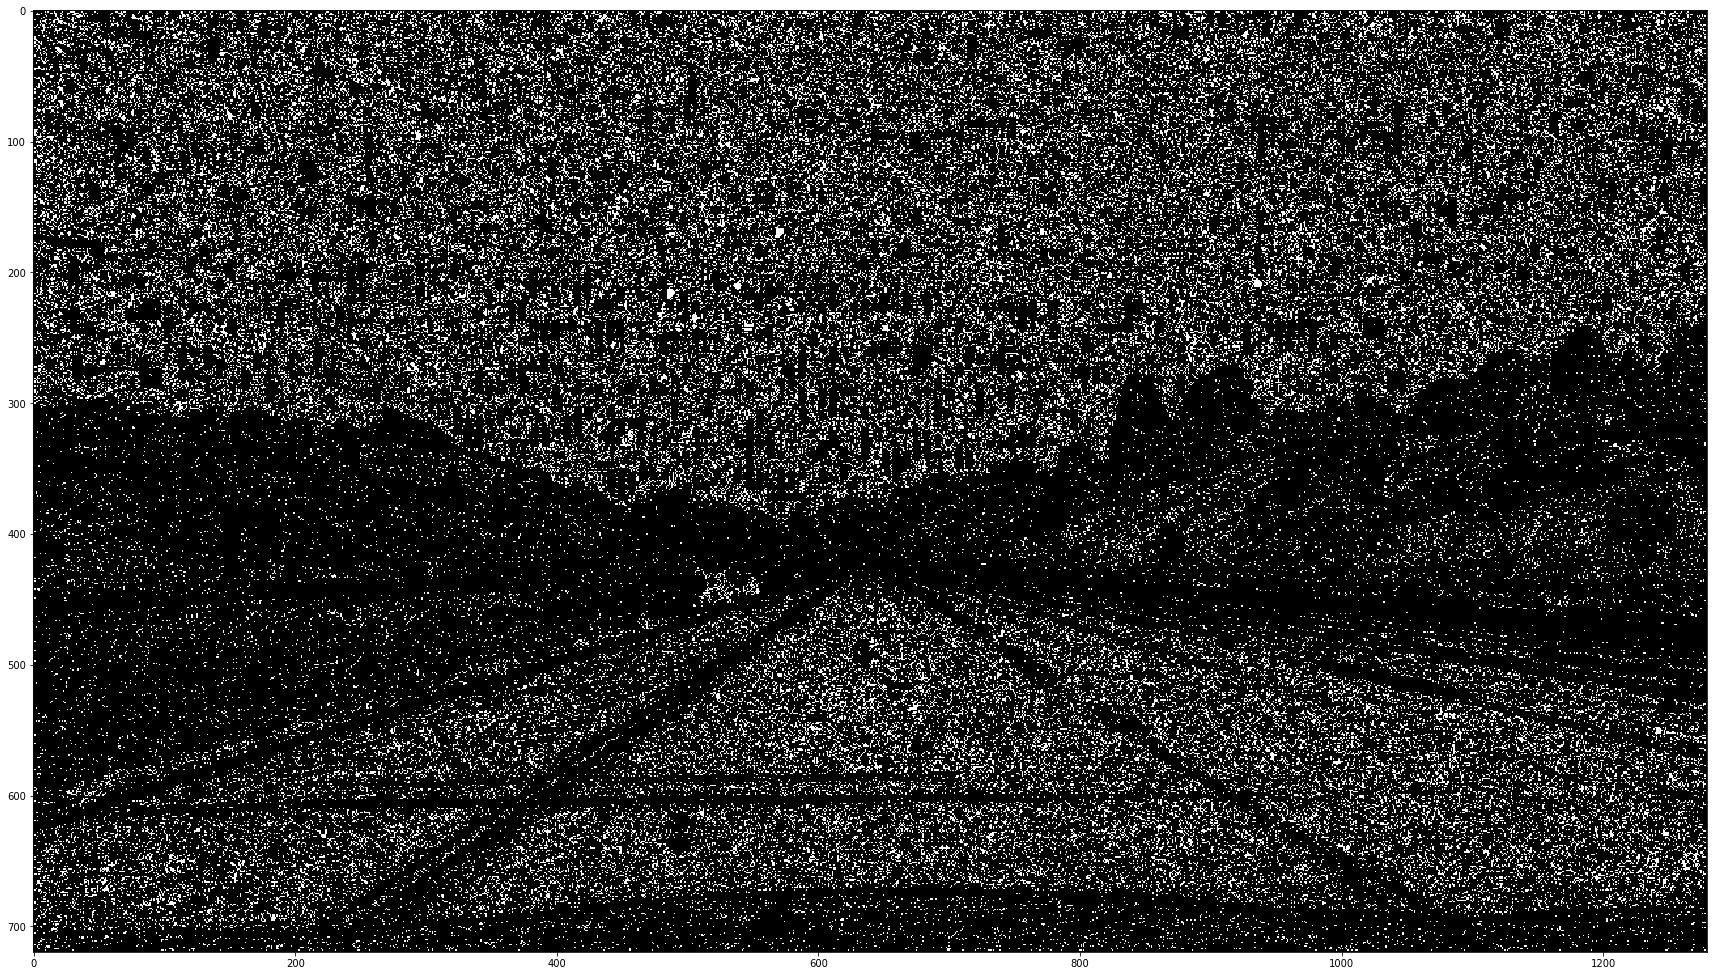

In [11]:
#Live widget to tune the direction thresholds
@widgets.interact(min_degree = (0, 90, 1), max_degree = (0, 90, 1) )
def adjust_mag(min_degree, max_degree):
    global road_dst
    figure, axis = plt.subplots(1, 1, figsize = (30,30))
    dir_img = dir_thresh(road_dst, 3, (min_degree * np.pi / 180, max_degree * np.pi / 180))
    axis.imshow(dir_img, cmap='gray')

## Combining thresholds to refine the results
__Options to choose:__

- __Color__ spaces (AND together)
- __Gradient__ (OR together) AND with __Direction__ 

Proposed: these to be OR together

### Color spaces

After experimenting, I chose __Red__ channel and __Val__ channel.

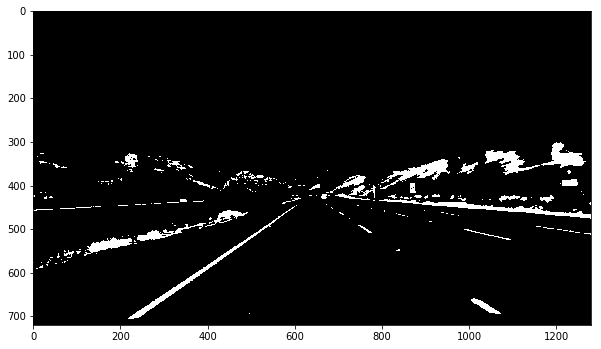

In [12]:
#Color channel only
combined_color = np.zeros((road_dst.shape[0], road_dst.shape[1]))

RGB_red = road_dst[:,:,0]

# road_dst_HLS = cv2.cvtColor(road_dst, cv2.COLOR_RGB2HLS)
# HLS_sat = road_dst_HLS[:,:,2]

road_dst_HSV = cv2.cvtColor(road_dst, cv2.COLOR_RGB2HSV)
HSV_val = road_dst_HSV[:,:,2]

red_thres = (175, 255)
val_thres = (170, 255)

#sat_thres = (100, 255)


color_criteria = ((RGB_red >= red_thres[0]) & (RGB_red <= red_thres[1])) \
                & ((HSV_val >= val_thres[0]) & (HSV_val <= val_thres[1])) 
                #& ((HLS_sat >= sat_thres[0]) & (HLS_sat <= sat_thres[1])) 

combined_color[color_criteria] = 255
figure, axis = plt.subplots(1, 1, figsize = (10,10))
axis.imshow(combined_color, cmap='gray')

figure.savefig("output_images/combined_color.png")

### Color spaces

__Sobel_x__, __Sobel_y__ OR __Magnitude__ AND with __Direction__

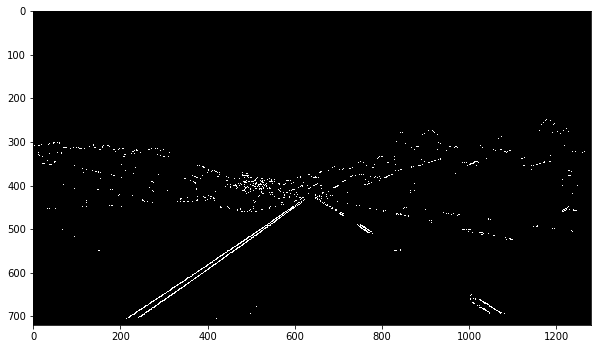

In [13]:
#Gradient color only
combined_gradient = np.zeros((road_dst.shape[0], road_dst.shape[1]))

sobelx_channel = abs_sobel_thresh(road_dst, orient='x', sobel_kernel=3, thresh = (40, 255))
sobely_channel = abs_sobel_thresh(road_dst, orient='y', sobel_kernel=3, thresh = (60, 255))

mag_channel = mag_thresh(road_dst, 3, (60, 255))

dir_channel = dir_thresh(road_dst, 3, (40 * np.pi / 180,75 * np.pi / 180))

gradient_criteria = (((sobelx_channel == 1) | (sobely_channel == 1) | (mag_channel == 1))) & (dir_channel == 1)

combined_gradient[gradient_criteria] = 255

figure, axis = plt.subplots(1, 1, figsize = (10,10))
axis.imshow(combined_gradient, cmap='gray')

figure.savefig("output_images/combined_gradient.png")

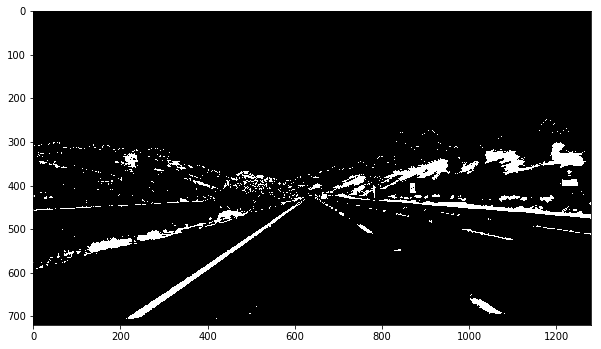

In [14]:
combined = np.zeros_like(combined_gradient) 

combined[(combined_gradient == 255) | (combined_color == 255)] = 255

figure, axis = plt.subplots(figsize=(10,10))
axis.imshow(combined, cmap='gray')

figure.savefig("output_images/combined_final.png")

## Perspective Transform

- two source and destination quadrilaterals 

In [15]:
def transform_source(width, height, width_offset, ref_width = 512, ref_height = 460):
    
    return np.float32([[width_offset, height],[ref_width, ref_height],[width - ref_width, ref_height],[width - width_offset, height]])
    
def transform_destination(width, height, width_offset):
    
    return np.float32([[width_offset, height], [width_offset, 0], [width - width_offset, 0], [width - width_offset, height]])

#transform the image
def warp(img, src, dst):
    
    width = img.shape[1]
    height = img.shape[0]
    
    #get the perspective transform matrix
    perspective_transform = cv2.getPerspectiveTransform(src, dst)
    
    #get the inverse perspective transform matrix
    #for the original image
    
    #get the transformed (or warped) result
    warped = cv2.warpPerspective(img, perspective_transform, (width, height), flags=cv2.INTER_LINEAR)    
    
    return warped, perspective_transform


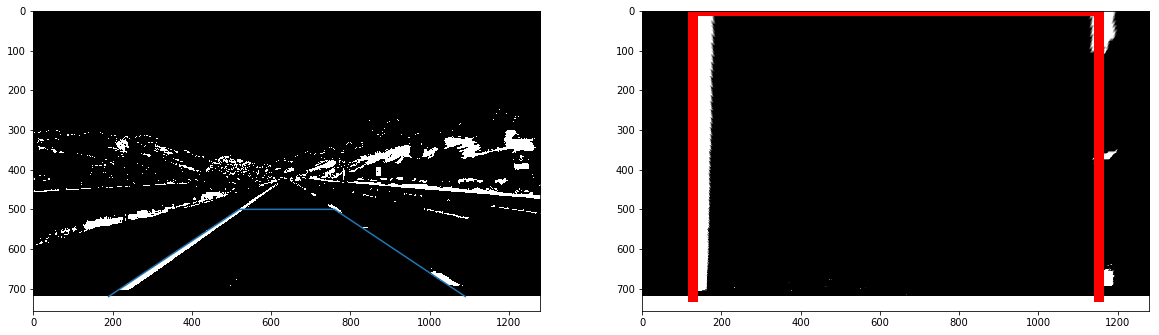

In [16]:
%matplotlib inline
width = combined.shape[1]
height = combined.shape[0]

#requires the test image to be nearly horizontally symmetrical
ref_width = 520
ref_height = 500
width_offset = 190

#transformed: transformed image
#T_mat: transformation matrix

source = transform_source(width, height, width_offset, ref_width, ref_height)
destination = transform_destination(width, height, 0.1 * width)

transformed, T_mat = warp(combined, source, destination)

figure, axis = plt.subplots(1, 2, figsize=(20, 10))
axis = axis.ravel()

axis[0].imshow(combined, cmap='gray')
axis[0].plot(source[:,0], source[:, 1])
axis[1].imshow(transformed, cmap='gray')
axis[1].plot(destination[:,0], destination[:,1], linewidth= 10, color = 'red')
figure.savefig("output_images/perspective_transform.png")

## Detect lane pixels and fit into the lane boundaries

Create histogram on the bottom half of the image to find the correct bases of the two lane lines.

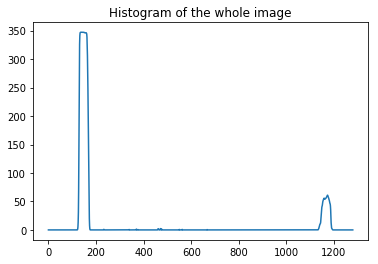

In [17]:
def histogram(img):
    #Grab the bottom half of the image
    
    bottom_half = img[img.shape[0] // 2 :, :] / 255
    
    #axis = 0: vertical
    #axis = 1: horizontal
    result = np.sum(bottom_half, axis = 0)

    return result

test_histogram = histogram(transformed)

plt.plot(test_histogram)
plt.title("Histogram of the whole image")
plt.autoscale(enable=True, axis='x', tight=False)
plt.figure()
plt.savefig("output_images/histogram.png")

#### Set up windows and window hyperparameters

In [27]:
def find_lane_pixels(warped_img, nwindows = 10, margin = 100, minpix = 100):
    #create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((warped_img, warped_img, warped_img)))
    
    #find the peak of the left and right halves of the histogram.
    #they will be the starting points for the left and right lines.
    hist = histogram(warped_img)
    
    midpoint = np.int(hist.shape[0]//2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint

    #Height of windows = height of image / number of windows
    window_height = np.int(transformed.shape[0] // nwindows)

    nonzero = transformed.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #current position to be updated later for each winddow in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    #Lists for left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    
    for window in range(nwindows):
        #Identify window boundaries in x and y (and right and left)
        win_y_low = transformed.shape[0] - (window+1) * window_height
        win_y_high = transformed.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        #Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),  
                    (255,0,0), 5)
        cv2.rectangle(out_img, 
                     (win_xright_low, win_y_low),
                    (win_xright_high, win_y_high), 
                    (255,0,0), 5)

        #Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        #Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        #if more than minpix pixels are found, next window will be on their mean position
        if len(good_left_inds) >= minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) >= minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    #Concate the array of indices (list of list of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)        
        right_lane_inds = np.concatenate(right_lane_inds)
    
    except Exception as e:
        print(e)
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img[lefty, leftx] = [0,255,0]
    out_img[righty, rightx] = [0,0,255]
    
    return leftx, lefty, rightx, righty, out_img

def search_around_poly(warped_img, last_left_fit_coeff, last_right_fit_coeff, nwindows = 9, margin = 100, minpix = 100):
    
    out_img = np.uint8(np.dstack((warped_img, warped_img, warped_img)))
    
    nonzero = warped_img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    left_midline = np.polyval(last_left_fit_coeff, nonzeroy)
    right_midline = np.polyval(last_right_fit_coeff, nonzeroy)
    
    
    left_lane_inds = (abs(left_midline - nonzerox) <= margin)
    right_lane_inds = (abs(right_midline - nonzerox) <= margin) 
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(img_shape, leftx, lefty, rightx, righty):
    
    left_fit_coeffs = np.polyfit(lefty, leftx, 2)
    right_fit_coeffs = np.polyfit(righty, rightx, 2)
    
    height = img_shape[0]
    ploty = np.linspace(0, height-1, height)
    
    try:
        left_fitx = np.polyval(left_fit_coeffs, ploty)
        right_fitx = np.polyval(right_fit_coeffs, ploty)
        
    except TypeError:
        #Avoid an error if 'left' or 'right_fit_coeffs' are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = np.polyval([1,1,0], ploty)
        right_fitx = np.polyval([1,1,0], ploty)

    return left_fitx, right_fitx, ploty

def draw_detected_lane_lines(warped_img, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, margin = 80):
    
    out_img = np.uint8(np.dstack((warped_img, warped_img, warped_img)))
    
    window_img = np.zeros_like(out_img)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 255, 0]
    
    #Generate a polygon to illustrate the search window area
    #and recast the xand y points into usable format for cv2.fillPoly()
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack[right_fitx + margin, ploty]))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    #Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0,150))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,0,150))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

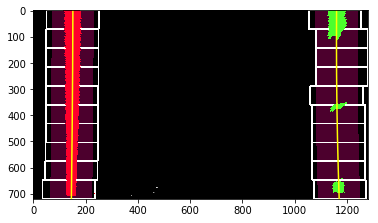

In [28]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(transformed)
left_fitx, right_fitx, ploty = fit_polynomial(transformed.shape, leftx, lefty, rightx, righty)

result = draw_detected_lane_lines(out_img[:,:,0], leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty)
plt.imshow(result)
plt.savefig("output_images/sliding_windows.png")

In [29]:
#We want to search around the detected lane curve, as this is where the next lane mostly detected.
#We might need to retrieve the previous left and right coefficients.
left_fit_coeffs = np.polyfit(lefty, leftx, 2)
right_fit_coeffs = np.polyfit(righty, rightx, 2)

print("Coeffs regressed to the left lane: ", left_fit_coeffs)
print("Coeffs regressed to the right lane: ", right_fit_coeffs)

Coeffs regressed to the left lane:  [ -8.30337696e-06  -2.09288352e-03   1.51665115e+02]
Coeffs regressed to the right lane:  [  2.90826328e-05  -7.10175079e-03   1.15987507e+03]


In [30]:
#Assume we have a new image frame.
new_frame = np.copy(transformed)

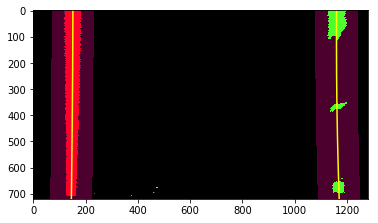

In [31]:
leftx, lefty, rightx, righty, output_img = search_around_poly(new_frame, left_fit_coeffs, right_fit_coeffs)

left_fitx, right_fitx, ploty = fit_polynomial(new_frame.shape, leftx, lefty, rightx, righty)

result = draw_detected_lane_lines(new_frame, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty)

plt.imshow(result)
plt.savefig("output_images/search_around_poly.png")

### Measure the curvature


In [32]:
def measure_curvature_pixels_by_coeffs(ploty, left_fit_coeffs, right_fit_coeffs):
    
    y_eval = np.max(ploty)
    
    #Calculation of R_curve
    A_l, B_l, C_l = left_fit_coeffs[0], left_fit_coeffs[1], left_fit_coeffs[2]
    A_r, B_r, C_r = right_fit_coeffs[0], right_fit_coeffs[1], right_fit_coeffs[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*A_l*y_eval + B_l) ** 2) ** (1.5) / abs(2*A_l)  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*A_r*y_eval + B_r) ** 2) ** (1.5) / abs(2*A_r)  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

def measure_curvature_pixels_by_data(ploty, left_fitx, right_fitx):
    left_fit_coeffs = np.polyfit(ploty, left_fitx, 2)
    right_fit_coeffs = np.polyfit(ploty, right_fitx, 2)

    return measure_curvature_pixels_by_coeffs(ploty, left_fit_coeffs, right_fit_coeffs)

print(measure_curvature_pixels_by_coeffs(ploty, left_fit_coeffs, right_fit_coeffs))

(60234.25248348694, 17223.486472486606)


In [33]:
def measure_curvature_real_by_data(ploty, left_fitx, right_fitx):

    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2) 
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    A_l, B_l, C_l = left_fit_cr[0], left_fit_cr[1], left_fit_cr[2]
    A_r, B_r, C_r = right_fit_cr[0], right_fit_cr[1], right_fit_cr[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    y_real = y_eval * ym_per_pix
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*A_l*y_real + B_l) ** 2) ** (1.5) / abs(2*A_l)  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*A_r*y_real + B_r) ** 2) ** (1.5) / abs(2*A_r)  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

print(measure_curvature_real_by_data(ploty, left_fitx, right_fitx))

(19778.399593659058, 5647.064567759744)


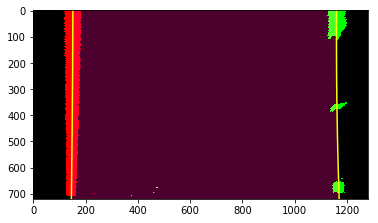

In [34]:
def draw_lane(warped_img, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty):
    
    out_img = np.uint8(np.dstack((warped_img, warped_img, warped_img)))
    
    window_img = np.zeros_like(out_img)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 255, 0]
    
    #Generate a polygon to illustrate the search window area
    #and recast the xand y points into usable format for cv2.fillPoly()
    
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack[right_fitx + margin, ploty]))])
    
    lane = np.hstack((left_line, right_line))
    
    #Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([lane]), (255,0,150))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

plt.imshow(draw_lane(transformed, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty))

In [35]:
from enum import Enum

class LineStatus(Enum):
    NORMAL = 0
    RESET = 1
    NOT_ENOUGH_DATA = 2
    FLUCTUATING = 3
    
# Define a class to receive the characteristics of each line detection
class Line(object):
    
    FILTER_LENGTH = 5
    DIFF_LIMIT = np.array([0.01, 1.0, 300.])
    TRUST_LIMIT = 1000
    TAIL_LIMIT = 100
    RESET_LIMIT = 5
        
    #Observation: the point of the lane nearest to the car does not change much
    
    def __init__(self):
        self.reset()
        
        
    def reset(self):
        self.count = 0
        self.status = LineStatus.RESET
        #was the line detected in the last iteration?
        self.detected = False  
        
        #x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.recent_coeffs = []  
        
        #radius of curvature of the line in some units
        self.curvature_in_meter = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
#         #x values for detected line pixels
#         self.allx = None  
#         #y values for detected line pixels
#         self.ally = None
    
        #lane position
        self.xpos = None
        self.warning = ""
    
    
    def measure_curvature_real_by_data(self, ploty, xm_per_pix = 3.7/700, ym_per_pix = 30/720):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
   
        # Make sure to feed in your real data instead in your project!
        real_coeff = np.polyfit(ploty * ym_per_pix, self.bestx * xm_per_pix, 2) 
        #Ax^2 + Bx + C
        A, B, C = real_coeff[0], real_coeff[1], real_coeff[2]

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        
        y_eval = np.max(ploty)

        y_real = y_eval * ym_per_pix

        ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
        self.curvature_in_meter = (1+(2*A*y_real + B) ** 2) ** (1.5) / abs(2*A)  ## Implement the calculation of the left line here

        return self.curvature_in_meter
    
    def sanity_check(self, new_coeff, x, ploty):
        
        if self.best_fit == None:
            self.warning = "no built-in fit. Update anyway"
            self.status = LineStatus.NORMAL
            return True
            
        if new_coeff == None or new_coeff == []:
            self.warning = "no new coeff"
            self.status = LineStatus.NOT_ENOUGH_DATA
            return False
            
        if len(x) < self.TRUST_LIMIT:
            self.warning = "not enough points"
            self.status = LineStatus.NOT_ENOUGH_DATA
            return False
        
        if abs(np.polyval(new_coeff, np.max(ploty)) - np.polyval(self.best_fit, np.max(ploty))) > self.TAIL_LIMIT:
            self.warning = "too diff tail"
            self.status = LineStatus.FLUCTUATING
            return False
        
        #return True if all the difference is less than the DIFF_LIMIT
        diff = np.abs(new_coeff - self.best_fit)       
        hasPassed = np.all(np.less(diff, self.DIFF_LIMIT))
        if not hasPassed:
            self.warning = "too diff coeff"
            self.status = LineStatus.FLUCTUATING
            
        return hasPassed
               
    def update(self, coeff, x, ploty):
        test = self.sanity_check(coeff, x, ploty)
        if test:
            self.detected = True
            self.recent_coeffs.append(coeff)

            #Odd the old coeffs
            if len(self.recent_coeffs) > self.FILTER_LENGTH:
                #fetch the most recent coeffs
                self.recent_coeffs = self.recent_coeffs[-self.FILTER_LENGTH:]

            self.best_fit = np.mean(self.recent_coeffs, axis=0)
            self.bestx = np.polyval(self.best_fit, ploty)
            self.recent_xfitted = np.polyval(coeff, ploty)
            self.measure_curvature_real_by_data(ploty)
            self.warning = "normal"
            self.count = 0
        else:
            self.detected = False   
            self.count += 1
           
    def checkNeedReset(self):
        if self.count >= self.RESET_LIMIT and self.status != LineStatus.NOT_ENOUGH_DATA:
            self.reset()
            self.warning = "reset"
            

## Entire pipeline (after camera calibration)

Undistort -> Threshold -> Perspective Transform -> Detect Lane -> Perspective Transform to match original 

In [38]:
def pipeline(frame):
    global mtx
    global dist
    global left_lane
    global right_lane
    
    undistorted = aCV.undistort_image(frame, mtx, dist)
    
    thresholded = aCV.threshold_image(undistorted)
    
    width = thresholded.shape[1]
    height = thresholded.shape[0]

    #requires the test image to be nearly horizontally symmetrical
    ref_width = 520
    ref_height = 500
    width_offset = 190
    margin = 50
    minpix = 80
    #transformed: transformed image
    #T_mat: transformation matrix

    source = aCV.transform_source(width, height, width_offset, ref_width, ref_height)
    destination = aCV.transform_destination(width, height, 0.1 * width)
    left_window = []
    right_window = []
    warped, T_mat, inv_mat = aCV.warp(thresholded, source, destination)
    
    if not left_line.detected or not right_line.detected:
        leftx, lefty, rightx, righty, out_img, left_window, right_window = aCV.scan_lane_pixels(warped, nwindows = 10, margin = margin, minpix = minpix)
        searchAroundPrev = False

    else:
        leftx, lefty, rightx, righty, out_img = aCV.search_around_poly(warped, left_line.best_fit, right_line.best_fit, margin = margin)
        searchAroundPrev = True
        lefty = lefty[::-1]
        leftx = leftx[::-1]
        righty = righty[::-1]
        rightx = rightx[::-1]
    
    left_fit_coeffs, right_fit_coeffs = aCV.fit_polynomial(leftx, lefty, rightx, righty, useWeight=True)
    
    height = frame.shape[0]
    ploty = np.linspace(0, height-1, height)
    
    left_line.update(left_fit_coeffs, leftx, ploty)
    right_line.update(right_fit_coeffs, rightx, ploty)
    
    warped_lane = aCV.fill_lane(warped, leftx, lefty, rightx, righty, 
                                left_line.bestx, right_line.bestx, ploty, 
                                left_window, right_window, searchAroundPrev)
    
    
    real_lane = cv2.warpPerspective(warped_lane, inv_mat, (warped_lane.shape[1], warped_lane.shape[0]), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undistorted, 1, real_lane, 0.3, 0)
    
    distance_center = aCV.measure_distance_from_lane_center(frame.shape, left_line.best_fit, right_line.best_fit)

        
    #Display data
    cv2.putText(result, "Left curvature: {0:.2f} m.  Right curvature: {1:.2f}m".format(left_line.curvature_in_meter, right_line.curvature_in_meter), 
                         (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA) 
    
    cv2.putText(result, "Distance from center: {0:2f} m.".format(distance_center), 
                         (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA)
    
    cv2.putText(result, "lm: {0}. rm: {1}".format(left_line.warning, right_line.warning),
                        (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA)
    
    left_line.checkNeedReset()
    right_line.checkNeedReset()
    return result

#### Test pipeline

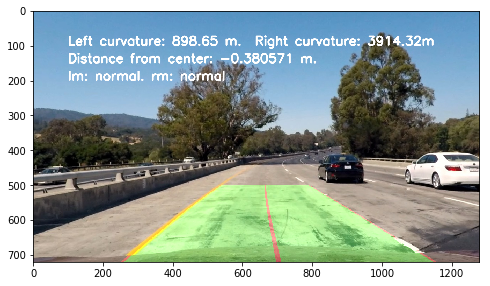

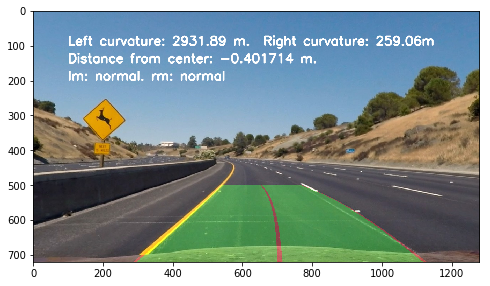

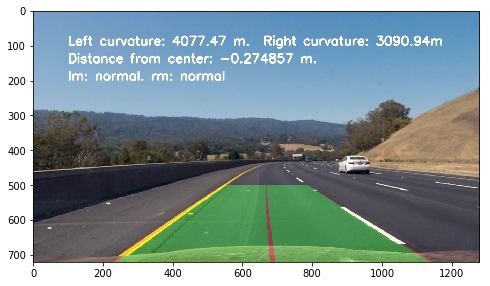

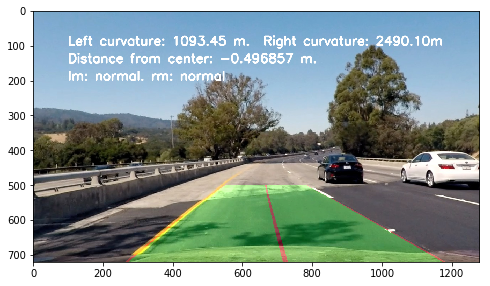

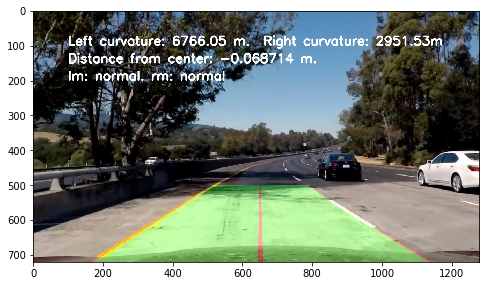

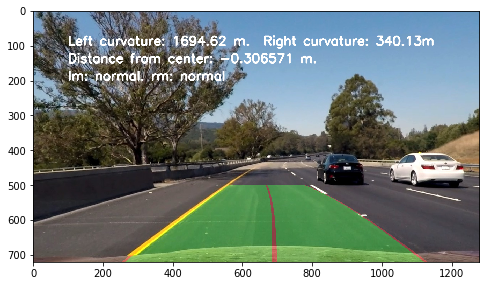

In [37]:
for image_name in glob.glob("test_images/test*.jpg"):
    left_line = Line()
    right_line = Line()
    road_img = mpimg.imread(image_name)
    result = pipeline(road_img)
    figure, axis = plt.subplots(figsize=(8,8))
    
    plt.imshow(pipeline(road_img))
    plt.savefig("output_images/" + image_name, bbox_inches='tight', pad_inches=0)
    plt.figure()

In [ ]:
left_line = Line()
right_line = Line()

clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(pipeline)

#NOTE: this function expects color images!!
video_output = 'output_videos/project_video.mp4'
%time video_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</videot
""".format(video_output))

In [ ]:
left_line = Line()
right_line = Line()
challenge_file = VideoFileClip('challenge_video.mp4')
challenge_clip = challenge_file.fl_image(pipeline)
#NOTE: this function expects color images!!

video_output = 'output_videos/challenge_video.mp4'
%time challenge_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</videot
""".format(video_output))

In [ ]:
left_line = Line()
right_line = Line()

clip2 = VideoFileClip('harder_challenge_video.mp4')
harder_clip = clip2.fl_image(pipeline)
#NOTE: this function expects color images!!
harder_output = 'output_videos/harder_video.mp4'
%time harder_clip.write_videofile(harder_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</videot
""".format(harder_output))